# Mixture of Gaussians

In this note, we will solve the mixture of Gaussians

This block contains some $\LaTeX$ macros.
$\newcommand{\E}{\mathbb{E}}$
$\renewcommand{\Re}{\mathbb{R}}$
$\newcommand{\oft}[1]{{^{(#1)}}}$
$\newcommand{\oftt}[2]{{^{(#1)#2}}}$

In [1]:
import util
from util import *
import numpy as np
import models
import mompy as mp
import cvxopt

np.set_printoptions(precision=3, suppress=True)
from IPython.display import display, Markdown, Math
from operator import mul
import sympy as sp

sp.init_printing()

## Noiseless Example

Let's construct a toy example for the rest of this document.

Let $\xi_1, ..., \xi_K \in \Re^D$ be the set of means. Let $c_1, ..., c_K \in \Re^D$ be the set of diagonal covariances.

In [2]:
k = 3
d = 3
degobs = 3
degmm = 2

sc.random.seed(101)
gm = models.GaussianMixtureModel.generate('', k, d, means='hypercube', cov='diagonal')

constraints = gm.polymom_all_constraints(degobs)
xis = gm.sym_means
covs = gm.sym_covs
sym_all = xis + covs
print 'The polynomial constraints are as follows'
display(constraints)

The polynomial constraints are as follows


With this machinery, we can compute the moment polynomials required for the moment method magic!

In [3]:
MM = mp.MomentMatrix(degmm, sym_all, morder='grevlex')
display(MM.row_monos)

In [4]:
cin = mp.solvers.get_cvxopt_inputs(MM, constraints)
solsdp = cvxopt.solvers.sdp(cin['c'], Gs=cin['G'], hs=cin['h'], A=cin['A'], b=cin['b'])


     pcost       dcost       gap    pres   dres   k/t
 0:  1.5220e+00  1.5220e+00  7e+01  7e+00  1e+00  1e+00
 1:  1.4614e+00  2.0162e+00  5e+00  1e+00  2e-01  7e-01
 2:  2.8147e+00  3.2337e+00  6e+00  9e-01  2e-01  5e-01
 3:  3.0181e+00  3.0598e+00  4e-01  7e-02  1e-02  5e-02
 4:  3.0577e+00  3.0634e+00  1e-01  2e-02  4e-03  9e-03
 5:  3.0642e+00  3.0657e+00  4e-02  6e-03  1e-03  2e-03
 6:  3.0651e+00  3.0652e+00  4e-03  6e-04  1e-04  2e-04
 7:  3.0653e+00  3.0654e+00  3e-04  5e-05  1e-05  1e-05
 8:  3.0654e+00  3.0654e+00  2e-05  3e-06  7e-07  1e-06
 9:  3.0654e+00  3.0654e+00  2e-06  3e-07  7e-08  1e-07
10:  3.0654e+00  3.0654e+00  3e-07  5e-08  9e-09  1e-08
Optimal solution found.


In [5]:
sol_lasserre = mp.extractors.extract_solutions_lasserre(MM, solsdp['x'], Kmax = k)
sol_dreesen = mp.extractors.extract_solutions_dreesen_proto(MM, solsdp['x'], Kmax = k)
trueparams = {}

for i in xrange(d):
    trueparams[xis[i]] = []
    trueparams[covs[i]] = []
    for j in xrange(k):
        trueparams[xis[i]].append(gm.means[i,j])
        trueparams[covs[i]].append(gm.sigmas[j,i,i])
print 'the true parameters'
display(trueparams)
print 'recovered parameters (Lasserre)'
display(sol_lasserre)
print 'recovered parameters (Dreesen)'
display(sol_dreesen)

the biggest singular value we are losing is 0.000307
the next biggest eigenvalue we are losing is 0.000307
the true parameters


recovered parameters (Lasserre)


recovered parameters (Dreesen)


## Now take samples!


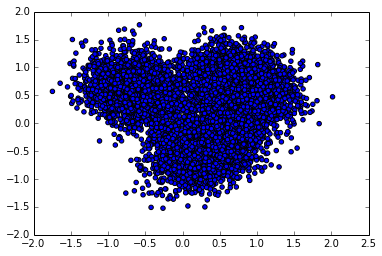

In [6]:
num_samples = 10000
X = gm.sample(num_samples)
import matplotlib.pyplot as plt
%matplotlib inline

import numpy.linalg

# plot after a random orthogonal projection
randdir,__,__ = np.linalg.svd(np.random.randn(d,2))
Y = X.dot(randdir[:,0:2])
plt.scatter(Y[:,0], Y[:,1]);

constraints_noisy = gm.polymom_all_constraints_samples(4, X)
display(constraints_noisy)

In [7]:
cin = mp.solvers.get_cvxopt_inputs(MM, constraints_noisy)
solsdp_noisy = cvxopt.solvers.sdp(cin['c'], Gs=cin['G'], hs=cin['h'], A=cin['A'], b=cin['b'])


     pcost       dcost       gap    pres   dres   k/t
 0:  1.8440e+00  1.8440e+00  6e+01  6e+00  1e+00  1e+00
 1:  1.5049e+00  2.0573e+00  5e+00  1e+00  2e-01  7e-01
 2:  2.8423e+00  3.3897e+00  9e+00  1e+00  2e-01  7e-01
 3:  3.0286e+00  3.0734e+00  5e-01  7e-02  2e-02  6e-02
 4:  3.0699e+00  3.0732e+00  4e-02  7e-03  1e-03  4e-03
 5:  3.0773e+00  3.0781e+00  1e-02  2e-03  4e-04  1e-03
 6:  3.0791e+00  3.0796e+00  1e-02  1e-03  3e-04  7e-04
 7:  3.0804e+00  3.0805e+00  2e-03  3e-04  6e-05  1e-04
 8:  3.0809e+00  3.0810e+00  1e-03  1e-04  3e-05  5e-05
 9:  3.0811e+00  3.0811e+00  2e-04  2e-05  4e-06  7e-06
10:  3.0811e+00  3.0811e+00  3e-05  4e-06  8e-07  1e-06
11:  3.0811e+00  3.0811e+00  1e-05  2e-06  3e-07  5e-07
12:  3.0811e+00  3.0811e+00  2e-06  2e-07  5e-08  8e-08
13:  3.0811e+00  3.0811e+00  2e-07  2e-08  4e-09  5e-09
Optimal solution found.


In [8]:
sol_lasserre_noisy = mp.extractors.extract_solutions_lasserre(MM, solsdp_noisy['x'], Kmax = k)
sol_dreesen_noisy = mp.extractors.extract_solutions_dreesen_proto(MM, solsdp_noisy['x'], Kmax = k)

print 'the true parameters'
display(trueparams)
print 'recovered parameters (Lasserre)'
display(sol_lasserre_noisy)
print 'recovered parameters (Dreesen)'
display(sol_dreesen_noisy)

the biggest singular value we are losing is 0.004391
the next biggest eigenvalue we are losing is 0.004391
the true parameters


recovered parameters (Lasserre)


recovered parameters (Dreesen)
